## Load Modules

In [1]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import functools
from anndata import AnnData

## Helper Functions

In [2]:
def non_negative_factorization_reimplementation(
        X: np.array, 
        W: Union[None, np.array]=None, 
        H: Union[None, np.array]=None, 
        n_components: Union[None, int]=None, 
        update_H: bool=True,
        max_iter: int=200
) -> tuple[np.array, np.array, int]:

    if n_components is None:
        if H is not None:
            n_components = H.shape[0]
        else:
            n_components = min(X.shape)
    if W is None:
        W = np.ones((X.shape[0], n_components))
    if H is None:
        H = np.ones((n_components, X.shape[1]))
    
    for _ in tqdm(range(max_iter)):
        W = (W.T * (H @ X.T) / (H @ H.T @ W.T + 1e-9)).T
        if update_H:
            H = (H * (W.T @ X) / (W.T @ W @ H + 1e-9))
    return W, H, max_iter

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def nmf_transfer(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference.X.toarray(), n_components=n_components)
    # NMF run 2
    W, H, _ = nmf_func(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }


def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:
    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [3]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

In [70]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
#sc.pp.filter_genes(adata_sp, min_counts=50)
#sc.pp.filter_genes(adata_sc, min_counts=50)
sc.pp.filter_genes(adata_sp, min_counts=50)
sc.pp.filter_genes(adata_sc, min_counts=50)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names
print(f"{len(shared_genes)=}")

len(shared_genes)=47


In [58]:
n_components = 20

res_sklearn = nmf_transfer(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=non_negative_factorization
)

res_reimplementation = nmf_transfer(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=functools.partial(non_negative_factorization_reimplementation, max_iter=500)
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 26278.45it/s]


### Baseline Reconstruction Quality of Spatial Data

n_components=20
Baseline reconstruction spatial data using sklearns NMF implementation


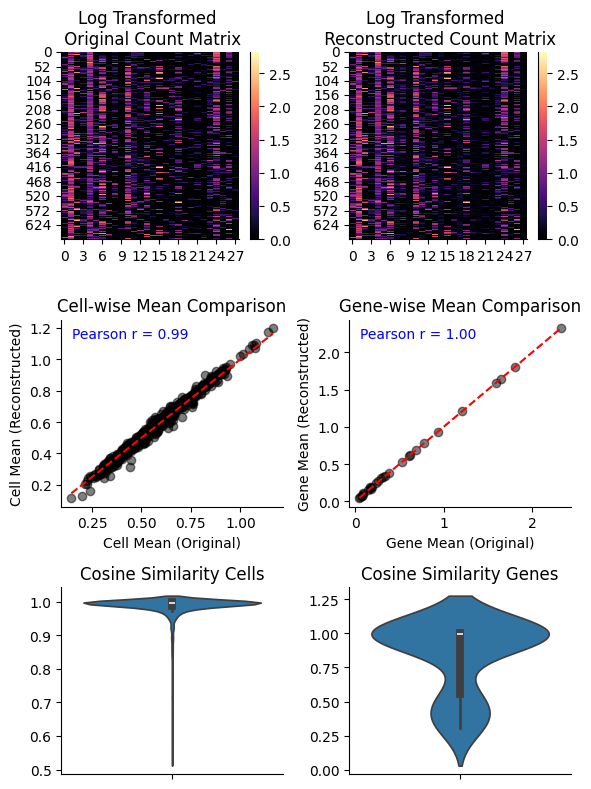

Baseline Reconstruction spatial data using manual implementation of NMF


100%|██████████| 500/500 [00:00<00:00, 10252.01it/s]


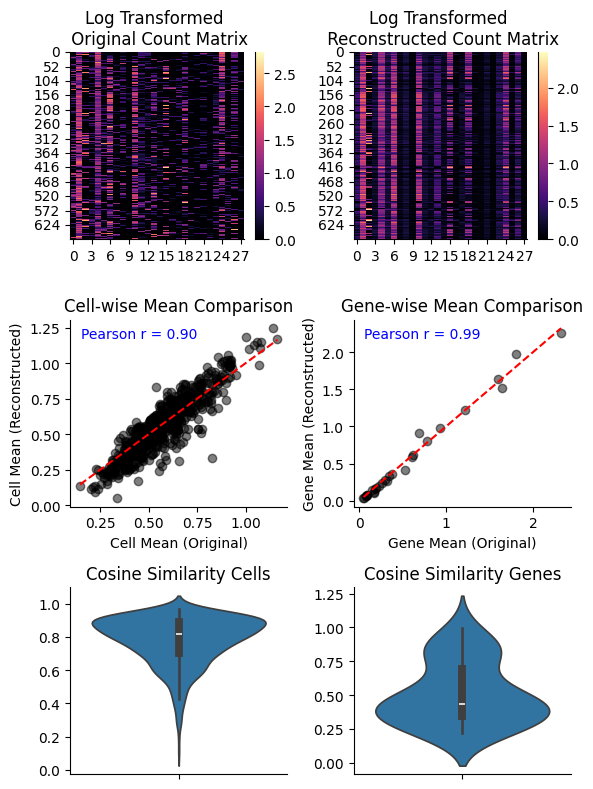

In [59]:
print(f"{n_components=}")
print("Baseline reconstruction spatial data using sklearns NMF implementation")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization, n_components=n_components)
)
print("Baseline Reconstruction spatial data using manual implementation of NMF")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization_reimplementation, n_components=n_components, max_iter=500)
)

### Reconstruction Quality of single cell reference data

n_components=20
Baseline reconstruction single cell data using sklearns NMF implementation


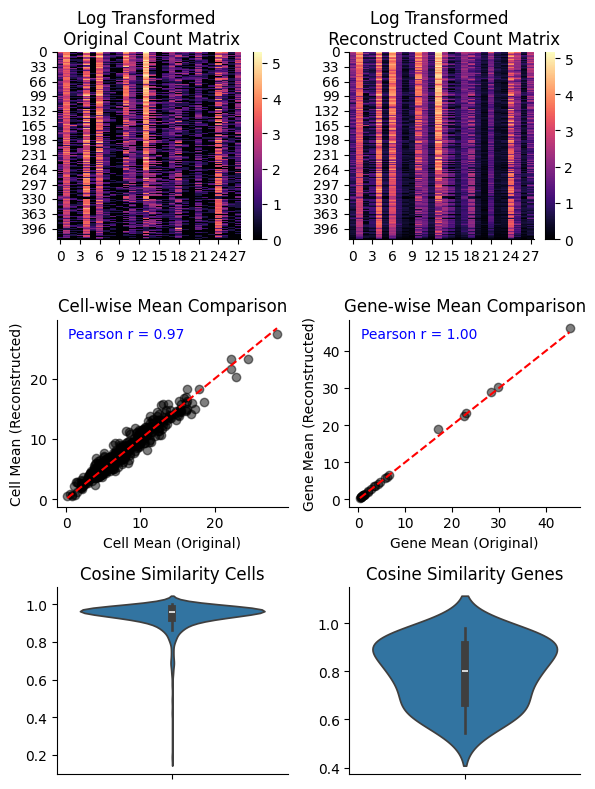

Baseline Reconstruction single cell data using manual implementation of NMF


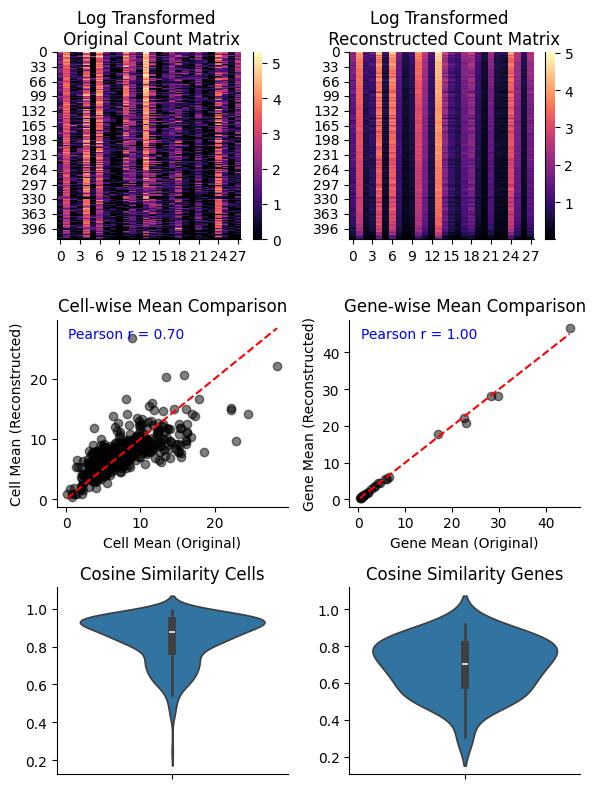

In [60]:
print(f"{n_components=}")
print("Baseline reconstruction single cell data using sklearns NMF implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_sklearn
 )

print("Baseline Reconstruction single cell data using manual implementation of NMF")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_reimplementation
 )

### Reconstruction Quality of spatial data with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF

n_components=20
Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation


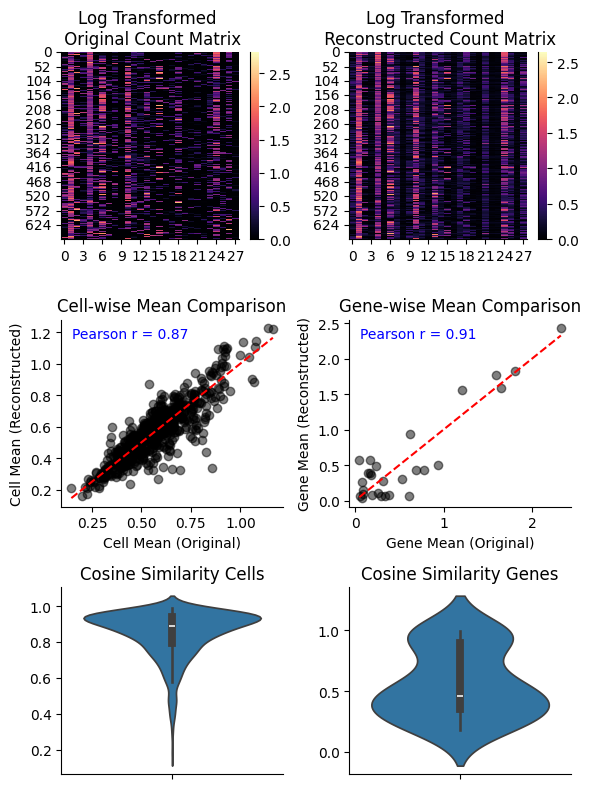

Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation


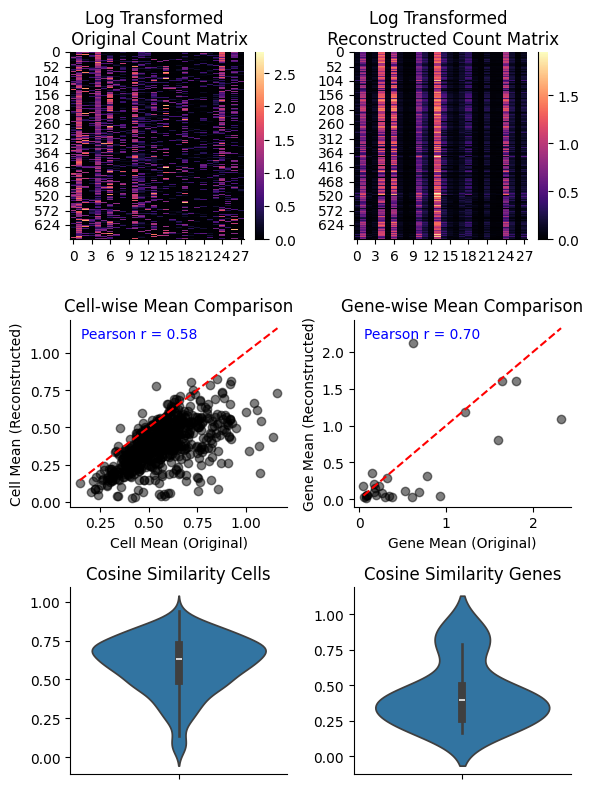

In [72]:
print(f"{n_components=}")
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_sklearn
 )
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_reimplementation
 )

### Randomly Reconstructed Matrix by sampling featurewise

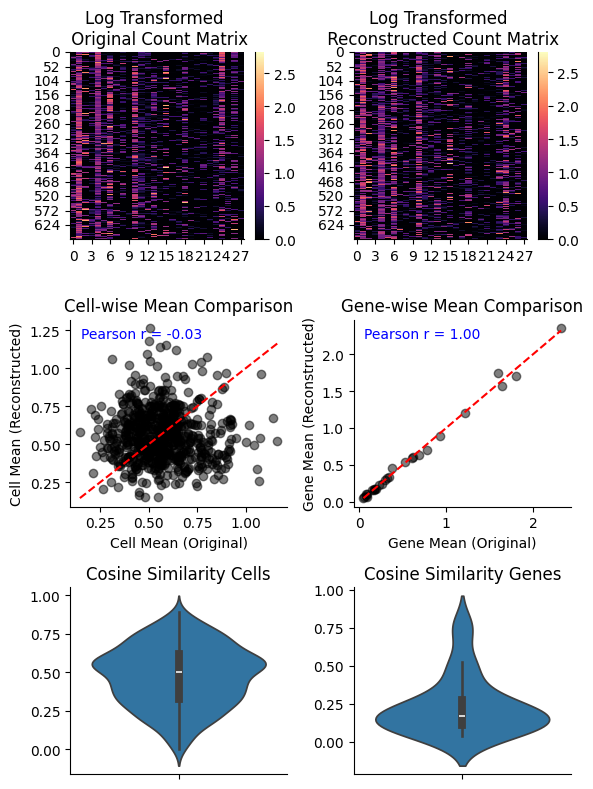

In [62]:
(lambda X:
 benchmark_reconstruction(
     X,
     np.apply_along_axis(lambda vec: np.random.choice(vec, size=len(vec), replace=True), axis=0, arr=X)
 ))(
    adata_sp[:, shared_genes].X.toarray()
    #adata_sc[:, shared_genes_mask_sc].X.toarray()
 )

In [84]:
def nmf_transfer_masked(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference.X.toarray()[:, shared_genes_mask_reference], n_components=n_components)
    # NMF run 2
    W, H, _ = nmf_func(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }

In [87]:
adata_sp.var_names

Index(['Acsl1', 'Ada', 'Adra2a', 'Agr3', 'Avil', 'Ccl9', 'Ccnl2', 'Ccr3',
       'Cd14', 'Cd44', 'Chrm1', 'Chrm3', 'Clca3b', 'Cmc1', 'Cps1', 'Cysltr2',
       'Elavl3', 'Fcna', 'Ffar1', 'Ffar2', 'Ffar3', 'Ffar4', 'Fzd1', 'Fzd10',
       'Fzd2', 'Fzd3', 'Fzd4', 'Fzd5', 'Fzd6', 'Fzd7', 'Fzd8', 'Fzd9', 'Galr3',
       'Gipr', 'Gpbar1', 'Gper1', 'Gpr55', 'H2-Eb1', 'Hmgb2', 'Hrh1', 'Hrh3',
       'Htr1b', 'Htr4', 'Htr5b', 'Ifnar1', 'Il10', 'Il3ra', 'Il5', 'Itgam',
       'Jaml', 'Kit', 'Klk1', 'Krt7', 'Lamp3', 'Lct', 'Lgr5', 'Lmx1a', 'Lpar1',
       'Lpar2', 'Lpar4', 'Lpar5', 'Lpar6', 'Maged2', 'Maoa', 'Marcksl1',
       'Mki67', 'Mptx2', 'Neat1', 'Net1', 'Nkg7', 'Nlrp6', 'P2ry10b', 'Pax6',
       'Ptgdr', 'Ptgdr2', 'Ptger1', 'Ptger4', 'Ptprcap', 'Rcor2', 'S1pr2',
       'S1pr4', 'Sdc1', 'Slc12a2', 'Slc18a1', 'Smo', 'Sox4', 'Sstr1', 'Sstr3',
       'Stmn1', 'Tbx21', 'Tbxa2r', 'Tm4sf4', 'Trpm5', 'Tspan13', 'Txndc5'],
      dtype='object')

In [128]:
mask = ~np.eye((len(shared_genes)), dtype=bool)
data = adata_sp[:, shared_genes].X.toarray().copy()

In [131]:
len(shared_genes)

47

In [135]:
data[np.newaxis, :] * mask

ValueError: operands could not be broadcast together with shapes (1,997,47) (47,47) 

In [140]:
mask = ~np.eye((len(shared_genes)), dtype=bool)
arr = adata_sp[:, shared_genes].X.toarray().copy()
result = arr[mask].reshape(mask.shape).T

IndexError: boolean index did not match indexed array along axis 0; size of axis is 997 but size of corresponding boolean axis is 47

In [132]:
np.where(mask[:, np.newaxis, :], data).shape

ValueError: either both or neither of x and y should be given

In [143]:
arr = np.array([[1,2,3], [4,5,6]])
mask = ~np.eye(3, dtype=bool)
print(mask.shape, arr.shape)

# Apply the mask using broadcasting and reshape
result = arr[np.newaxis, :] * mask  # This creates a 2D array by broadcasting
result = result[mask].reshape(mask.shape[0], -1)
print(result)

(3, 3) (2, 3)


ValueError: operands could not be broadcast together with shapes (1,2,3) (3,3) 

In [146]:
np.tile(mask, (arr.shape[0], 1))

array([[False,  True,  True],
       [ True, False,  True],
       [ True,  True, False],
       [False,  True,  True],
       [ True, False,  True],
       [ True,  True, False]])

In [174]:
arr = adata_sp[:, shared_genes].X.toarray().copy()  
mask = ~np.eye(arr.shape[1], dtype=bool)
expanded_mask = np.tile(mask, (arr.shape[0], 1))
result = arr.repeat(mask.shape[0], axis=0)[expanded_mask].reshape(arr.shape[0], mask.shape[0], -1)
result.shape

(997, 47, 46)

In [178]:
test = (lambda X, mask:
 X.repeat(mask.shape[0], axis=0)[np.tile(mask, (X.shape[0], 1))].reshape(X.shape[0], mask.shape[0], -1))(
     adata_sp[:, shared_genes].X.toarray().copy(),
     ~np.eye(len(shared_genes), dtype=bool)
 )

In [259]:
W_init, H_init, _ = non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X.toarray(), n_components=4)

In [260]:
test_h = (lambda X, mask:
 X.repeat(mask.shape[0], axis=0)[np.tile(mask, (X.shape[0], 1))].reshape(X.shape[0], mask.shape[0], -1))(
     H_init,
     ~np.eye(len(shared_genes), dtype=bool)
 )

In [262]:
test_h.shape

(4, 47, 46)

In [261]:
test[:, 1, :].shape

(997, 46)

In [238]:
adata_sp[:, shared_genes].X.toarray()

array([[0.        , 0.        , 2.5325668 , ..., 0.        , 0.        ,
        0.84245837],
       [0.        , 0.        , 1.6432515 , ..., 2.2199748 , 0.        ,
        0.7724774 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 3.3458817 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.57144916, 2.6173067 , ..., 0.        , 0.        ,
        0.        ],
       [1.9232421 , 0.61044186, 3.393058  , ..., 0.        , 0.40174246,
        0.        ]], dtype=float32)

In [263]:
test_h[:,1,:].shape

(4, 46)

In [244]:
H = np.random.choice(4, (4, 47))

In [242]:
W, H, _ = non_negative_factorization(adata_sp[:, shared_genes].X.toarray(), H=H, init="custom", update_H=False)

TypeError: H should have the same dtype as X. Got H.dtype = int64.

In [252]:
test[:, 1, :].shape

(997, 46)

In [273]:
for i in range(5):
    W, H, _ = non_negative_factorization(test[:, i, :], H=test_h[:, i, :], init="custom", update_H=False)

In [267]:
W.shape

(997, 4)

In [277]:
np.apply_along_axis(lambda a: a[0] @ a[1], (np.random.choice(4, (3,3), np.random.choice(4, (3,3)))), axis=0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [279]:
np.array([non_negative_factorization(test[:, i, :], H=test_h[:, 1, :], init="custom", update_H=False)[0] for i in range(5)]).shape

(5, 997, 4)

In [ ]:
[non_negative_factorization()]

In [185]:
H_init.shape

(4, 47)

In [183]:
test.mean(axis=2).shape

(997, 47)

In [150]:
result

array([[[2, 3],
        [1, 3],
        [1, 2]],

       [[5, 6],
        [4, 6],
        [4, 5]]])

In [141]:
import numpy as np

# Example arrays
arr1 = np.array([1, 2, 3])
arr2 = np.array([10, 20, 30])

# Vectorized addition using broadcasting
result = arr1[:, np.newaxis] + arr2
result

array([[11, 21, 31],
       [12, 22, 32],
       [13, 23, 33]])

In [122]:
(~np.eye(3, dtype=bool)).shape[0]

3

In [116]:
np.array([1,2,3])

array([1, 2, 3])

In [142]:
import numpy as np

arr = np.array([1, 2, 3])
mask = ~np.eye(3, dtype=bool)

# Apply the mask using broadcasting and reshape
result = arr[np.newaxis, :] * mask  # This creates a 2D array by broadcasting
result = result[mask].reshape(mask.shape[0], -1)
print(result)

[[2 3]
 [1 3]
 [1 2]]


In [123]:
np.array([1,2,3])[~np.eye(3, dtype=bool)].reshape(3, -1)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [118]:
np.array([[2,3], [1,3], [1,2]])

array([[2, 3],
       [1, 3],
       [1, 2]])

In [85]:
nmf_transfer_masked(adata_sp, adata_sc, n_components=5, nmf_func=non_negative_factorization)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


{'adata_query_array': array([[0.        , 0.        , 2.5325668 , ..., 0.        , 0.        ,
         0.84245837],
        [0.        , 0.        , 1.6432515 , ..., 2.2199748 , 0.        ,
         0.7724774 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 3.3458817 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.57144916, 2.6173067 , ..., 0.        , 0.        ,
         0.        ],
        [1.9232421 , 0.61044186, 3.393058  , ..., 0.        , 0.40174246,
         0.        ]], dtype=float32),
 'adata_reference_array': array([[22.,  1., 11., ...,  1.,  2.,  0.],
        [17.,  8.,  6., ...,  0.,  4.,  0.],
        [11.,  5., 17., ...,  0.,  4.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 3.,  0.,  1., ...,  0.,  2.,  0.],
        [ 1.,  0.,  0., ...,  0.,  2.,  0.]], dtype=float32),
 'shared_genes_mask_query': array([ True,  True,